In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
from tqdm import tnrange
import torch.optim as optim
from   torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')
%matplotlib inline

In [2]:
# Model
class Autoenc(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(Autoenc,self).__init__()
        self.fc_e = nn.Linear(784,hidden_dim)
        self.fc_lat = nn.Linear(hidden_dim,latent_dim)
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim,784)
            
    def encoder(self,x_in):
        x = F.relu(self.fc_e(x_in.view(-1,784)))
        lat = self.fc_lat(x)
        return lat
    
    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        x_out = F.sigmoid(self.fc_d2(z))
        return x_out.view(-1,1,28,28)
    
    
    def forward(self,x_in):
        z_lat = self.encoder(x_in)
        x_out = self.decoder(z_lat)
        return x_out, z_lat

model = Autoenc()
model

Autoenc(
  (fc_e): Linear(in_features=784, out_features=500)
  (fc_lat): Linear(in_features=500, out_features=20)
  (fc_d1): Linear(in_features=20, out_features=500)
  (fc_d2): Linear(in_features=500, out_features=784)
)

In [3]:
%%time
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Data loaders
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

model = Autoenc().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

#train
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output, lat = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './dc_img_aut/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder.pth')

epoch [1/100], loss:0.0155
epoch [2/100], loss:0.0127
epoch [3/100], loss:0.0122
epoch [4/100], loss:0.0103
epoch [5/100], loss:0.0100
epoch [6/100], loss:0.0117
epoch [7/100], loss:0.0104
epoch [8/100], loss:0.0106
epoch [9/100], loss:0.0095
epoch [10/100], loss:0.0082
epoch [11/100], loss:0.0086
epoch [12/100], loss:0.0088
epoch [13/100], loss:0.0090
epoch [14/100], loss:0.0093
epoch [15/100], loss:0.0090
epoch [16/100], loss:0.0083
epoch [17/100], loss:0.0093
epoch [18/100], loss:0.0079
epoch [19/100], loss:0.0081
epoch [20/100], loss:0.0082
epoch [21/100], loss:0.0087
epoch [22/100], loss:0.0094
epoch [23/100], loss:0.0076
epoch [24/100], loss:0.0084
epoch [25/100], loss:0.0086
epoch [26/100], loss:0.0095
epoch [27/100], loss:0.0085
epoch [28/100], loss:0.0094
epoch [29/100], loss:0.0078
epoch [30/100], loss:0.0080
epoch [31/100], loss:0.0090
epoch [32/100], loss:0.0094
epoch [33/100], loss:0.0110
epoch [34/100], loss:0.0091
epoch [35/100], loss:0.0090
epoch [36/100], loss:0.0087
e

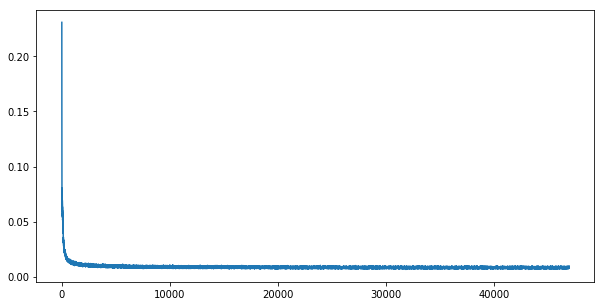

Wall time: 8min 28s


In [5]:
%%time
batch_size = 128
learning_rate = 1e-3

# Data loaders
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

model = Autoenc().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)
#Train
def Train (model, optimizer, dataloader, epochs = 100):
    losses = []
    for i in range(100):
        for data in dataloader:
            img, _ = data
            x_in = Variable(img).cuda()
            optimizer.zero_grad()
            x_out,z_lat = model(x_in)
            loss = criterion(x_out, x_in)
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
    return losses

train_losses = Train(model, optimizer, trainloader)
plt.figure(figsize = (10,5))
plt.plot(train_losses)
plt.show()

In [6]:
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
#Test
def Test (model, dataloader):
    running_loss = 0.0
    for data in dataloader:
        img, _ = data
        x_in = Variable(img).cuda()
        x_out,z_lat = model(x_in)
        loss = criterion(x_out, x_in)
        running_loss = running_loss + (loss.data[0]*x_in.size(0))
    return running_loss/len(dataloader.dataset)

test_loss = Test(model,testloader)
print (test_loss)

0.008140530052781106


In [7]:
# Train, test and visualize reconstruction using a 2D latent space
model2 = Autoenc(latent_dim=2).cuda()
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = Train(model2,optimizer2,trainloader)
test2_loss = Test(model2,testloader)

print(test2_loss)

0.04015801410675049


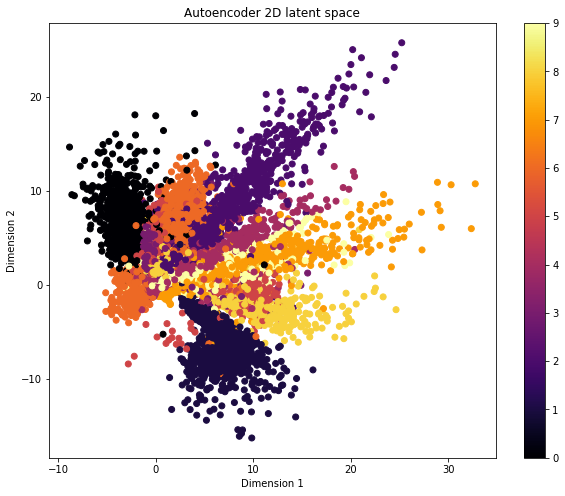

In [8]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_lat_x, z_lat_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        x_in = Variable(images).cuda()
        z_lat = model.encoder(x_in)
        z_lat_x = np.append(z_lat_x,z_lat[:,0].cpu().data.numpy())
        z_lat_y = np.append(z_lat_y,z_lat[:,1].cpu().data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(10,8))
    plt.title("Autoencoder 2D latent space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.scatter(z_lat_x,z_lat_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

In [9]:
#Visualize test data encodings on the latent space
def get_latent(model,dataloader):
    latent, all_labels = [], []
    for images,labels in dataloader:
        x_in = Variable(images).cuda()
        lat = model.encoder(x_in)
        latent.extend(lat[:,:].cpu().data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    return np.array(latent), all_labels

latent, all_labels = get_latent(model,testloader)
print (len(latent))

10000


In [10]:
%%time
latent_proj = TSNE(n_components=2).fit_transform(latent)

Wall time: 5min 1s


In [16]:
%%time
latent_proj2 = TSNE(n_components=2, perplexity = 50).fit_transform(latent)

Wall time: 6min 31s


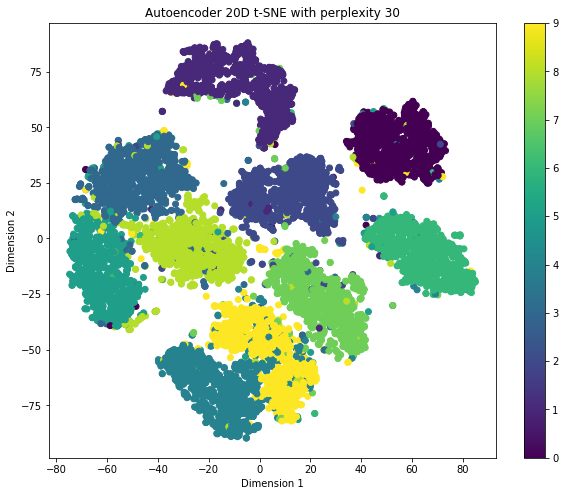

In [18]:
plt.figure(figsize=(10,8))
plt.title("Autoencoder 20D t-SNE with perplexity 30")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(latent_proj[:, 0], latent_proj[:, 1], c = all_labels)
plt.colorbar()
plt.show()

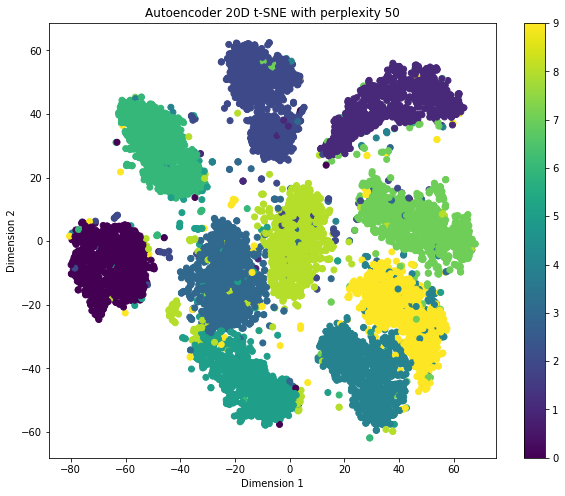

In [19]:
plt.figure(figsize=(10,8))
plt.title("Autoencoder 20D t-SNE with perplexity 50")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(latent_proj2[:, 0], latent_proj2[:, 1], c = all_labels)
plt.colorbar()
plt.show()

Text(0.5,1,'Perplexity 100')

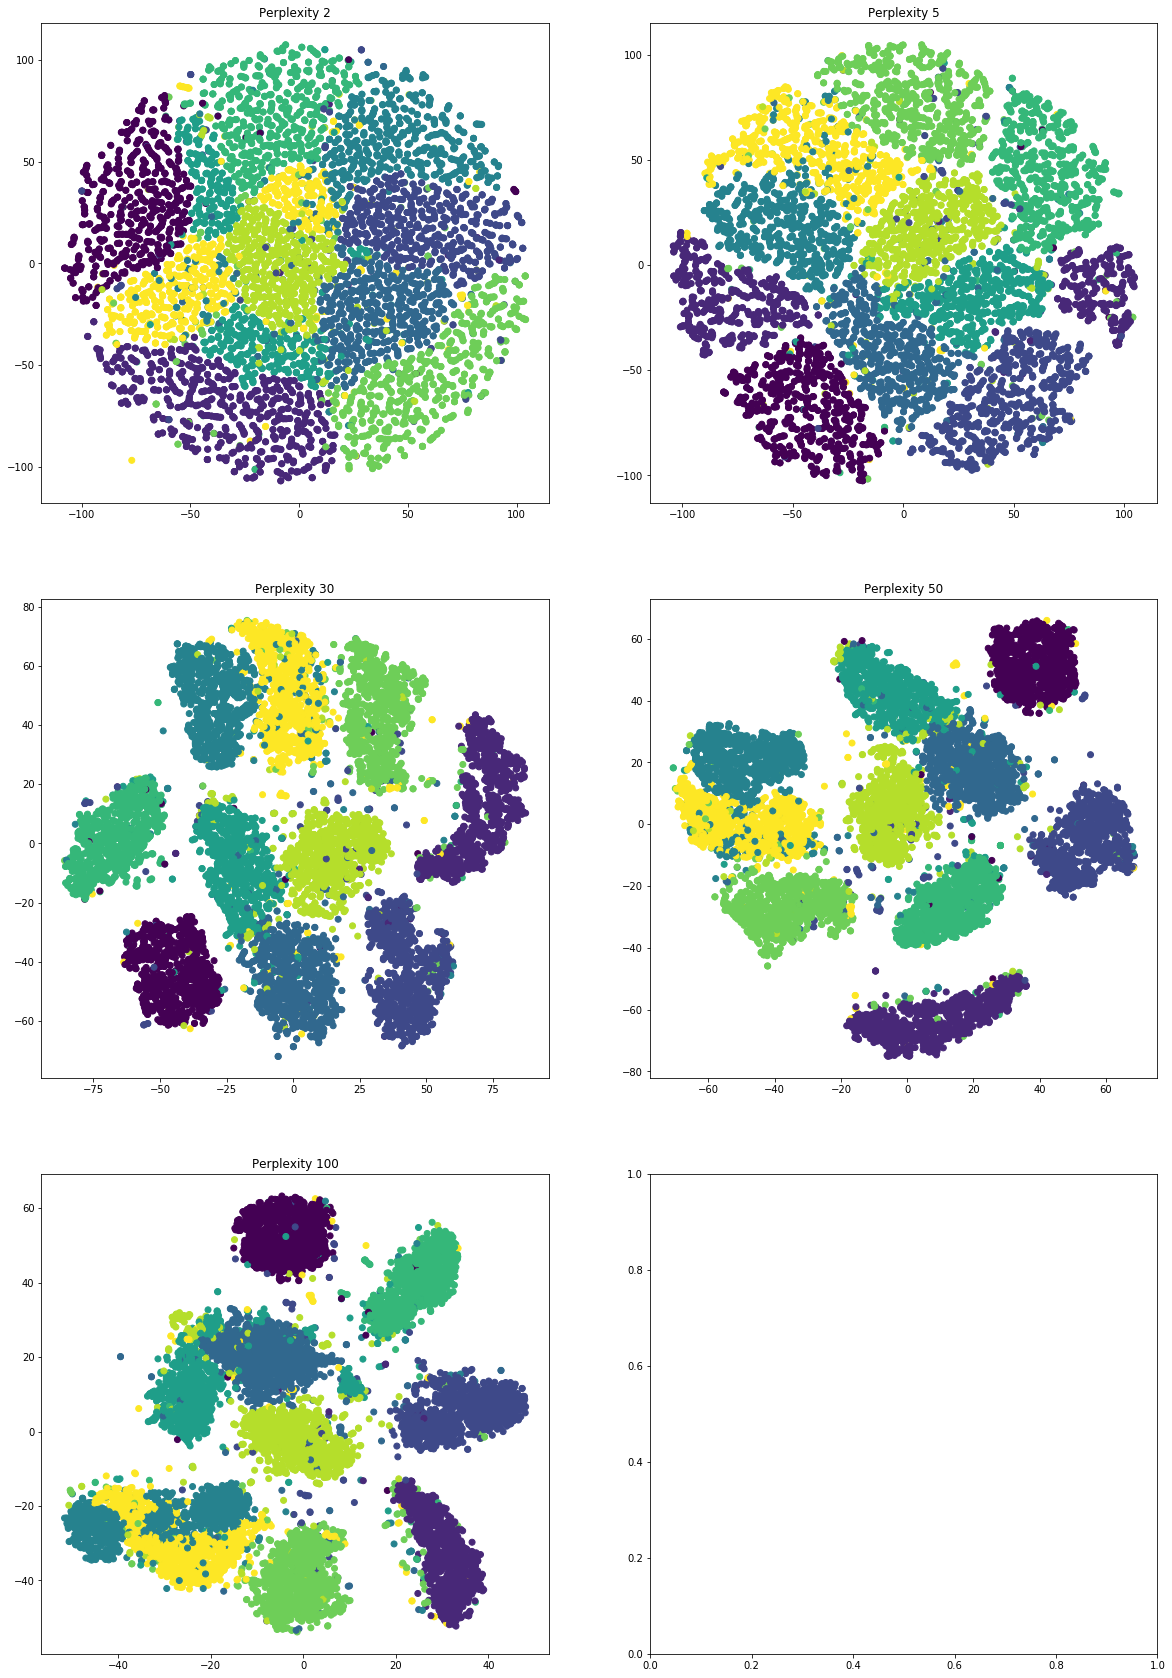

In [76]:
f, axarr = plt.subplots(3, 2, figsize=(20,30))

latent_proj = TSNE(n_components=2, perplexity=2).fit_transform(latent)
axarr[0, 0].scatter(latent_proj[:, 0], latent_proj[:, 1], c=all_labels)
axarr[0, 0].set_title('Perplexity 2')

latent_proj = TSNE(n_components=2, perplexity=5).fit_transform(latent)
axarr[0, 1].scatter(latent_proj[:, 0], latent_proj[:, 1], c=all_labels)
axarr[0, 1].set_title('Perplexity 5')

latent_proj = TSNE(n_components=2, perplexity=30).fit_transform(latent)
axarr[1, 0].scatter(latent_proj[:, 0], latent_proj[:, 1], c=all_labels)
axarr[1, 0].set_title('Perplexity 30')

latent_proj = TSNE(n_components=2, perplexity=50).fit_transform(latent)
axarr[1, 1].scatter(latent_proj[:, 0], latent_proj[:, 1], c=all_labels)
axarr[1, 1].set_title('Perplexity 50')

latent_proj = TSNE(n_components=2, perplexity=100).fit_transform(latent)
axarr[2, 0].scatter(latent_proj[:, 0], latent_proj[:, 1], c=all_labels)
axarr[2, 0].set_title('Perplexity 100')

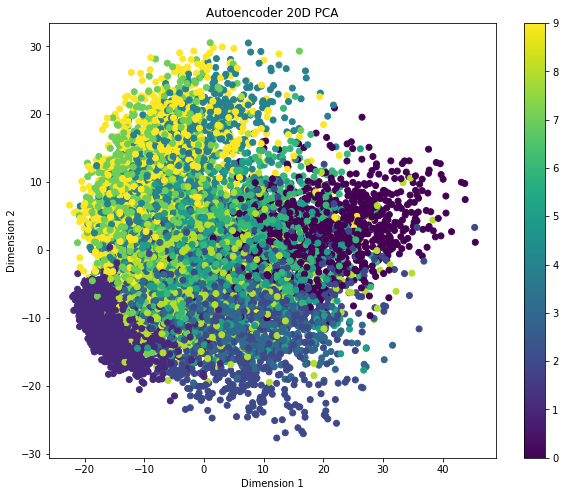

In [21]:
pca = PCA(n_components=2)
latent_pca =  pca.fit_transform(latent)
plt.figure(figsize=(10,8))
plt.title("Autoencoder 20D PCA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=all_labels)
plt.colorbar()
plt.show()

In [22]:
import umap

In [23]:
%%time
embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.001,
                      metric='correlation').fit_transform(latent)

Wall time: 21.1 s


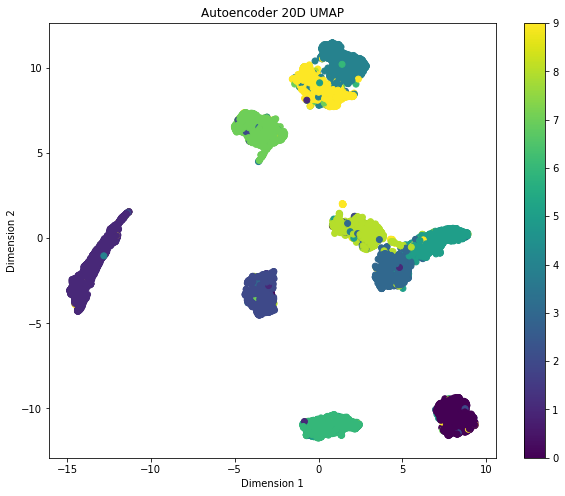

In [26]:
plt.figure(figsize=(10,8))
plt.title("Autoencoder 20D UMAP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels)
plt.colorbar()
plt.show()

In [6]:
__author__ = 'SherlockLiao'

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:0.2038
epoch [2/100], loss:0.1778
epoch [3/100], loss:0.1640
epoch [4/100], loss:0.1498
epoch [5/100], loss:0.1626
epoch [6/100], loss:0.1469
epoch [7/100], loss:0.1440
epoch [8/100], loss:0.1574
epoch [9/100], loss:0.1424
epoch [10/100], loss:0.1326
epoch [11/100], loss:0.1487
epoch [12/100], loss:0.1398
epoch [13/100], loss:0.1460
epoch [14/100], loss:0.1353
epoch [15/100], loss:0.1338
epoch [16/100], loss:0.1395
epoch [17/100], loss:0.1405
epoch [18/100], loss:0.1369
epoch [19/100], loss:0.1391
epoch [20/100], loss:0.1323
epoch [21/100], loss:0.1390
epoch [22/100], loss:0.1369
epoch [23/100], loss:0.1335
epoch [24/100], loss:0.1402
epoch [25/100], loss:0.1423
epoch [26/100], loss:0.1302
epoch [27/100], loss:0.1339
epoch [28/100], loss:0.1331
epoch [29/100], loss:0.1352
epoch [30/100], loss:0.1285
epoch [31/100], loss:0.1335
epoch [32/100], loss:0.1341
epoch [33/100], loss:0.1287
epoch [34/100], loss:0.1280
epoch [35/100], loss:0.1265
epoch [36/100], loss:0.1250
e